# Menu <a class="anchor" id="menu"></a>

* [1. Les systèmes de recommandation](#intro)
* [2. Analyses exploratoires](#eda)
    * [2.1 `articles_metadata.csv`](#articles_metadata)
    * [2.2 `clicks_hour_xxx.csv`](#clicks_hour)

# Préparatifs 

In [1]:
import pickle
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm  #, uniform

In [2]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, x_label=None, y_label="Nombre de commandes"):

    fig = plt.figure(figsize=(15, 4))
    ax = sns.barplot(data=data_)
    if show_values:
        ax.bar_label(ax.containers[0])
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

In [3]:
def explore_quantitative(data, col_name):
    dt = data[col_name]
    print(f'----- UNIVARIATE ANALYSIS for "{col_name}" -----\n',dt.describe(),'\n', sep='\n')

    fig = plt.figure(figsize=(15, 8))

    ax = plt.subplot(2, 2, 1)
    sns.boxplot(x=dt[dt.notnull()])
    plt.title(f"Boxplot for '{col_name}'")

    ax = plt.subplot(2, 2, 2)
    sns.kdeplot(dt, color='red')
    plt.title(f"Density plot for '{col_name}'")

    ax = plt.subplot(2, 2, 4)
    ax.set_title(f"QQplot for {col_name}")
    qqplot(data[data[col_name].notnull()][col_name], norm, fit=True, line="45", ax=ax)

    ###  Missing
    total_size = data.shape[0]
    total_size_nonull = data[col_name].notnull().sum()
    total_size_null = data[col_name].isnull().sum()
    percent_v = 100/total_size*total_size_null

    ax = plt.subplot(2, 2, 3)
    plt.pie(list([total_size_null, total_size_nonull]), labels=["", ""], autopct=lambda x: f"{x:.2f}%", shadow=False)
    plt.title(f"Distribution between rows with and without '{col_name}' values")
    plt.legend(["MISSING"], loc='lower center', bbox_to_anchor=(0, 0))

    fig.tight_layout()
    plt.show()

    print(f"'{col_name}' is missing {total_size_null} over {total_size} ({percent_v:.2f}%)")

---
---
# 1. Les sytèmes de recommandation <a class="anchor" id="intro"></a> [⇪](#menu)

> Le but des systèmes de recommandation est de chercher des similarités entre utilisateurs ou éléments à recommander (livres, films, articles, vétements...) sur la base d'indicateurs permettant de définir de manière implicite ou explicite le degré de satisfaction lié à ces éléments. Une fois les éléments similaires identifiés, on peut recommander les X premiers ou tirer au hasard dans les X premiers etc.

<img src='medias/recommender_matrix.png' width=700>

> ### Dans les systèmes de recommandation, on a 3 approches généralement admises:
> 1. Collaborative Filtering
> 2. Content-based Filtering
> 3. Hybrid recommenders

<img src='medias/collaborative_vs_content_filtering.png' width=700>

> **Collaborative Filtering**<br>
> Le filtrage collaboratif est un ensemble de méthodes qui se basent uniquement sur *les interactions entre les utilisateurs et les éléments* qui ont été enregistrées, afin de produire de nouvelles recommandations.<br>
> <img src='medias/collaborative_filtering.png' width=700>
>
> 1. **Memory Based**
>    * **User-based or user-user collaborative filtering**<br>
>        Dans cette approche, la matrice d'évaluation *(rating matrix)* est utilisée pour trouver des **utilisateurs** similaires sur la base des évaluations qu'ils ont donné.<br>
>        L'un des algorithmes possible dans ce cas est le *Centered-KNN* *(KNNWithMeans)*
>    * **Item-based or item-item collaborative filtering**<br>
>        Dans cette approche, la matrice d'évaluation *(rating matrix)* est utilisée pour trouver des **articles** similaires sur la base des évaluations que leur attribuent les utilisateurs.<br>
>        L'un des algorithmes possible dans ce cas est le *Centered-KNN* *(KNNWithMeans)*<br><br>
> 2. **Model Based**
>    * **Matrix factorization**<br>
>        cette approche qui est la principale solution des model based, peut être considéré comme la décomposition d'une grande matrice en un produit de plus petites matrices. Le nombre de ces facteurs peut aller de un à des centaines, voire des milliers.<br>
>        Le nombre de facteurs latents est l'un des éléments qui doivent être optimisés pendant la formation du modèle. <br>
>        Le nombre de facteurs latents affecte les recommandations d'une manière telle que plus le nombre de facteurs est élevé, plus les recommandations sont personnalisées. Mais un trop grand nombre de facteurs peut conduire à un surajustement du modèle.
>
>        Il existe plusieurs algorithmes pouvant correspondre à cette approche:
>        * SVD / SVD++
>        * PCA / NMF
>        * Autoencoders (Neural Networks)

> **Content-based Filtering**<br>
> L'approche basée sur le contenu utilise des informations disponibles *(en plus des scores)* sur les utilisateurs et/ou les articles. Dans ce cas, on utilise donc les caractéristiques des articles pour recommander d'autres articles similaires à ceux que l'utilisateur aime, mais en s'appuyant également sur les actions précédentes, des commentaires, ou d'autres infos disponibles.<br>
> <img src='medias/content_filtering.png' width=700>

> **Hybrid recommenders**<br>
> Un système de recommandation hybride est un type particulier de système de recommandation qui peut être considéré comme la combinaison entre le *Collaborative Filtering* et le *Content-based Filtering*.



---
---
# 2. Analyses Exploratoires <a class="anchor" id="eda"></a> [⇪](#menu)

Le jeu de données proposé par Globo.com propose de nombreux articles, mais tous ne sont pas pertinents pour notre projet...

## 2.1 `articles_metadata.csv` <a class="anchor" id="articles_metadata"></a> [⇪](#menu)

> articles_metadata.csv - CSV file with metadata information about all (364047) published articles 

In [4]:
data_articles = pd.read_csv('data/news-portal-user-interactions-by-globocom/articles_metadata.csv')
display(data_articles.sample(5), data_articles.shape)

,article_id,category_id,created_at_ts,publisher_id,words_count
52652,52652,106,1515575590000,0,177
359371,359371,455,1454600825000,0,137
216048,216048,351,1508964951000,0,128
136211,136211,255,1514650358000,0,196
45616,45616,92,1429297068000,0,183


(364047, 5)

>#### Ce sont les informations permettant de décrire les articles *(nous n'avons accès ni aux titres ni aux textes des articles)*
> - `article_id` est le code d'identification unique de chaque article publié
> - `category_id` est le code d'identification unique de la catégorie à laquelle apprtient l'article
> - `created_at_ts` est le nombre de millisecondes écoulé entre le 01/01/1970 et la moment où l'article à été publié
> - `publisher_id` est le code d'identification unique de l'éditeur de l'article *(j'imagine que c'est prévu pour pouvoir s'ouvrir à d'autres éditeurs si ce n'est pas encore le cas)*
> - `words_count` est nombre de mots présents dans l'article
>
> Ce jeu de données est composé de **364K articles** décrites par **5 variables**

### 2.1.1 Vérifications de base <a class="anchor" id="articles_metadata_uni"></a> [⇪](#menu)

In [5]:
data_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


### Ajustons les types de colonnes pour faciliter le travail d'analyse

In [6]:
for col in ['article_id', 'category_id', 'publisher_id']:
    data_articles[col] = data_articles[col].astype('category')

In [7]:
data_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   article_id     364047 non-null  category
 1   category_id    364047 non-null  category
 2   created_at_ts  364047 non-null  int64   
 3   publisher_id   364047 non-null  category
 4   words_count    364047 non-null  int64   
dtypes: category(3), int64(2)
memory usage: 18.8 MB


### Vérifions les valeurs *(min, max, mean etc.)*

In [8]:
pd.set_option('float_format', '{:.0f}'.format)

In [9]:
data_articles.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
created_at_ts,364047,1474070237328,42930380229,1159355675000,1444924843500,1489422449000,1509890951000,1520943150000
words_count,364047,191,60,0,159,186,218,6690


In [10]:
data_articles.describe(exclude='number', datetime_is_numeric=True).T

,count,unique,top,freq
article_id,364047,364047,0,1
category_id,364047,461,281,12817
publisher_id,364047,1,0,364047


>#### Il se pourrait que l'on ait quelques valeurs aberrantes.
> - ⚠️ `created_at_ts` : les dates vont du **27/09/2006 11:14:35 GMT au 13/03/2018 12:12:30 GMT**, alors que le jeu de données est décrit comme allant du  **01/10/2017 au 16/10/2017**. Donc même si l'on considère que les articles peuvent être plus vieux que les click utilisateurs, il est peu probable qu'un article de 2018 trouve légitimment sa place dans notre jeu de données.
>
> - ⚠️ `words_counts` : la taille des articles varie de **0 à 6690**... Un article de 0 mots n'a aucun sens, et 6690 est très au dessus de la moyenne de 186 mots ou même du 3ème quartile de 218 mots.
>

>#### En revanches les autres colonnes ne semblent pas présenter de valeurs aberrantes
> - `article_id` : chaque article possède bien un ID unique
> - `category_id` : on constate qu'il y a 461 catégories d'articles, mais il n'y a pas de raison de croire que c'est un problème.
> - `publisher_id` : on constate qu'il y a 1 seul éditeur, mais c'est tout à fait attendu (on peut imaginer que seul l'équipe de Globo.com peut publier sur Globo.com)

### Regardons plus en détails la colonne `created_at_ts`

----- UNIVARIATE ANALYSIS for "created_at_ts" -----

count          364047
mean    1474070237328
std       42930380229
min     1159355675000
25%     1444924843500
50%     1489422449000
75%     1509890951000
max     1520943150000
Name: created_at_ts, dtype: float64




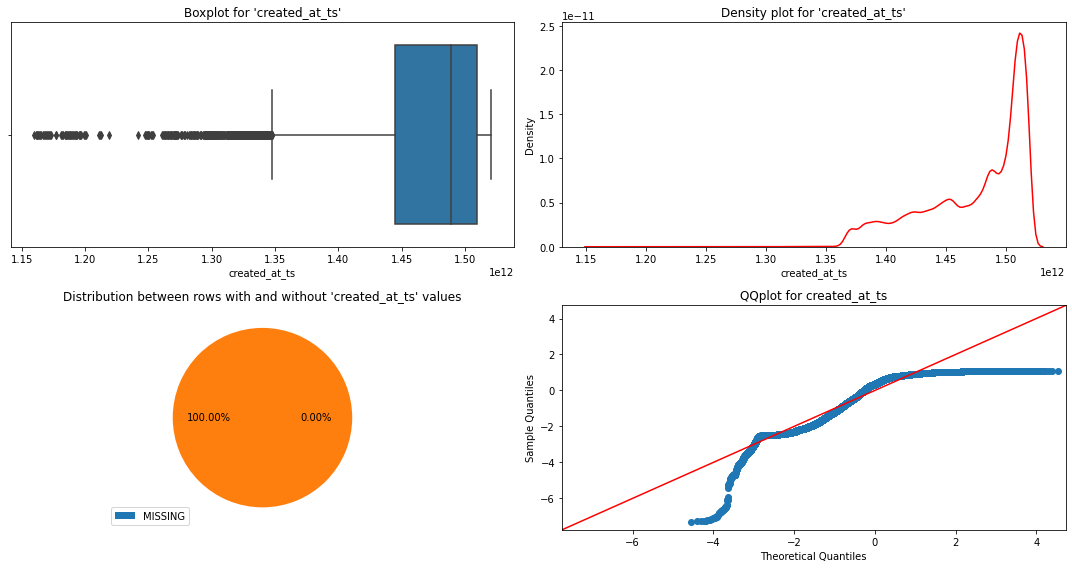

'created_at_ts' is missing 0 over 364047 (0.00%)


In [11]:
explore_quantitative(data_articles, 'created_at_ts')

### Regardons plus en détails la colonne `words_count`

----- UNIVARIATE ANALYSIS for "words_count" -----

count   364047
mean       191
std         60
min          0
25%        159
50%        186
75%        218
max       6690
Name: words_count, dtype: float64




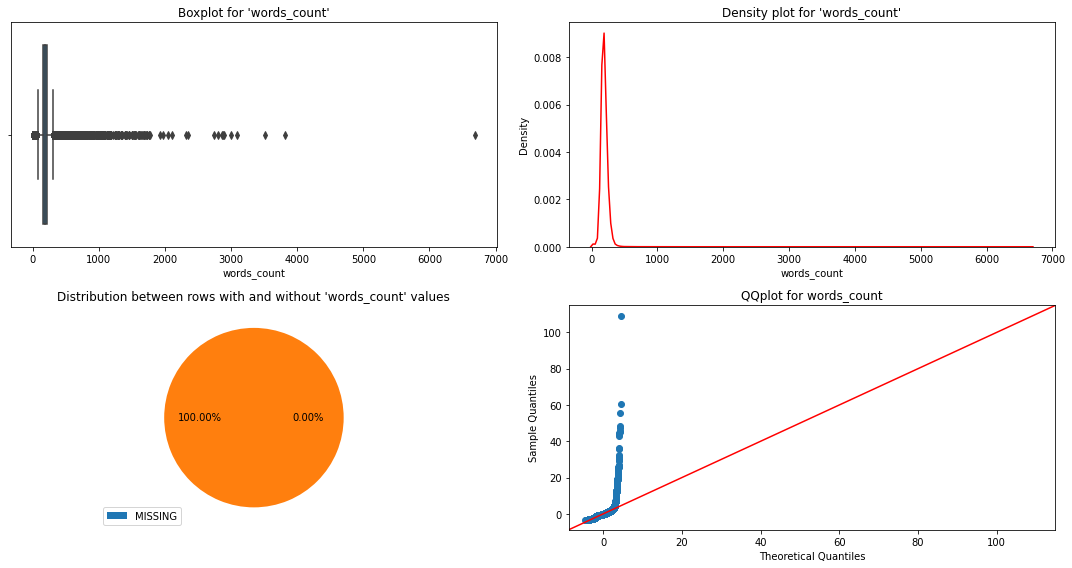

'words_count' is missing 0 over 364047 (0.00%)


In [14]:
explore_quantitative(data_articles, 'words_count')

### 2.1.2 Analyses multivariées <a class="anchor" id="articles_metadata_multi"></a> [⇪](#menu)

### Regardons la repartition des articles dans le temps

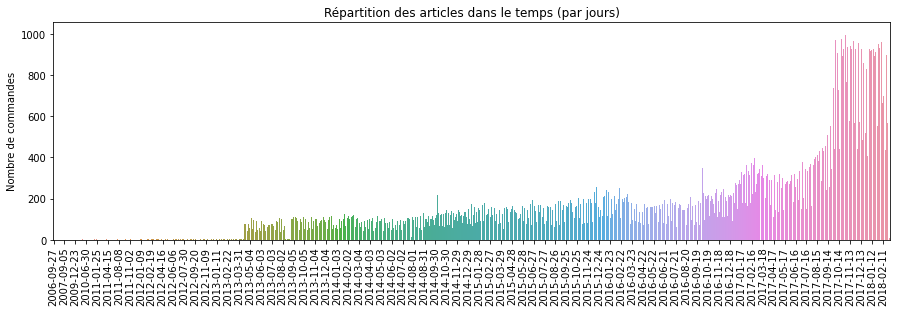

In [12]:
selection = data_articles[['article_id', 'created_at_ts']].copy()
selection['short_date'] = selection['created_at_ts'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count']).T

plot_bars(selection, "Répartition des articles dans le temps (par jours)", labels_modulo=30, show_values=False)

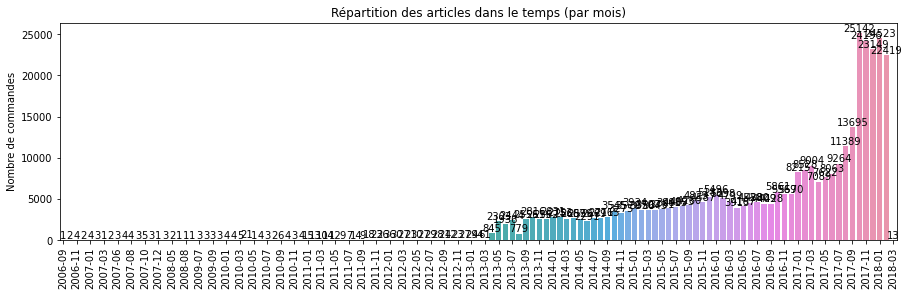

In [13]:
selection = data_articles[['article_id', 'created_at_ts']].copy()
selection['short_date'] = selection['created_at_ts'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count']).T

plot_bars(selection, "Répartition des articles dans le temps (par mois)", labels_modulo=2, show_values=True)

---
>#### `TODO`  done ✅ | todo ❌ |
> - ❌ Supprimer les articles dont les valeurs sont plus récentes que le plus récent des clicks ?<br>(où vont ils être naturellement éliminés losque l'on ne va retenir que les articles aillant reçu un minimum de clicks ?)
> - ❌ Supprimer la colonne `publisher_id` qui ne présente qu'une unique valeur.

## 2.2 `clicks_hour_XXX.csv` <a class="anchor" id="clicks_hour"></a> [⇪](#menu)
> clicks.zip - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.

### Concatenate all clicks CSV files

clicks.zip - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.

In [6]:
datalist = []
for i in range(0, 385):
    data_tmp = pd.read_csv(f'data/news-portal-user-interactions-by-globocom/clicks/clicks_hour_{i:03}.csv')
    data_tmp['hour'] =  i
    datalist.append(data_tmp)

data_clicks = pd.concat(datalist)
display(data_clicks.head(), data_clicks.shape)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,0
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,0
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,0
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,0
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,0


(2988181, 13)

## Load clicks sample (1 Hour - id=000)

In [4]:
data_clicks_1H = pd.read_csv('data/news-portal-user-interactions-by-globocom/clicks_sample.csv')
display(data_clicks_1H.head(), data_clicks_1H.shape)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


(1883, 12)

In [5]:
data_clicks_1H.describe(include='all')

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,1883.000000,1.883000e+03,1.883000e+03,1883.000000,1883.000000,1.883000e+03,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,355.893787,1.506828e+15,1.506828e+12,3.459904,176717.848646,1.506830e+12,3.917153,2.305895,12.113648,1.491768,18.774827,1.764206
std,206.162865,8.679628e+08,8.679468e+05,3.037467,82324.177259,1.064938e+07,0.410461,1.062301,7.825735,2.007772,7.083400,1.225679
min,0.000000,1.506825e+15,1.506825e+12,2.000000,2137.000000,1.506827e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,181.500000,1.506827e+15,1.506827e+12,2.000000,108854.000000,1.506828e+12,4.000000,1.000000,2.000000,1.000000,13.000000,1.000000
50%,353.000000,1.506828e+15,1.506828e+12,3.000000,157541.000000,1.506828e+12,4.000000,3.000000,17.000000,1.000000,21.000000,1.000000
75%,537.000000,1.506828e+15,1.506828e+12,4.000000,236697.500000,1.506829e+12,4.000000,3.000000,19.000000,1.000000,25.000000,2.000000
max,706.000000,1.506829e+15,1.506829e+12,24.000000,363291.000000,1.506998e+12,4.000000,4.000000,20.000000,11.000000,28.000000,7.000000


## Load the Articles' Embedding

articles_embeddings.pickle Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the CHAMELEON's ACR module (see paper for details) for 364047 published articles.
P.s. The full text of news articles could not be provided due to license restrictions, but those embeddings can be used by Neural Networks to represent their content. See this paper for a t-SNE visualization of these embeddings, colored by category.

In [9]:
file = open('data/news-portal-user-interactions-by-globocom/articles_embeddings.pickle',"rb")
article_embedding = pickle.load(file)

In [10]:
article_embedding

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [11]:
article_embedding.shape

(364047, 250)

### Select users with more than `min_clicks`

In [12]:
min_clicks_users = 2

In [13]:
count_users_clicks = data_clicks.groupby('user_id')['session_id'].count().sort_values()
count_users_clicks

user_id
322896       2
97261        2
239894       2
239895       2
239898       2
          ... 
15275      746
80350      783
15867      900
73574      939
5890      1232
Name: session_id, Length: 322897, dtype: int64

In [14]:
select_ids = [k for k,v in count_users_clicks.iteritems() if v >= min_clicks_users]
data_clicks[ data_clicks.click_article_id.isin(select_ids) ]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,0
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,0
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,0
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,0
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1,384
2565,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2,384
2566,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2,384
2567,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2,384


In [15]:
data_clicks.shape

(2988181, 13)

### Select articles with more than `min_clicks`

In [16]:
min_clicks_articles = 5

In [17]:
count_articles_clicks = data_clicks.groupby('click_article_id')['session_id'].count().sort_values()
count_articles_clicks

click_article_id
3             1
120371        1
120365        1
120361        1
120347        1
          ...  
123909    23122
234698    23499
336221    23851
272143    28943
160974    37213
Name: session_id, Length: 46033, dtype: int64

In [18]:
select_ids = [k for k,v in count_articles_clicks.iteritems() if v >= min_clicks_articles]
data_clicks[ data_clicks.click_article_id.isin(select_ids) ]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,0
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,0
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,0
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,0
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1,384
2565,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2,384
2566,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2,384
2567,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2,384


In [19]:
data_clicks.shape

(2988181, 13)

In [20]:
data_clicks[ data_clicks.click_article_id == 160974]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour
116,1849,1506840642126600,1506840642000,3,160974,1506840758261,4,1,17,11,28,2,4
1483,6534,1506858794306387,1506858794000,4,160974,1506902635141,4,1,17,1,21,1,9
2155,6781,1506859246224642,1506859246000,5,160974,1506948604990,4,1,17,1,19,2,9
3455,9261,1506863737242232,1506863737000,51,160974,1506936567602,4,1,17,1,8,1,10
334,10044,1506865213106063,1506865213000,2,160974,1506865245940,4,1,17,1,13,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,121790,1508147696406437,1508147696000,2,160974,1508148458232,4,1,17,1,13,2,367
12198,291291,1508156761121462,1508156761000,2,160974,1508157764367,4,1,17,1,25,5,369
9538,62759,1508178332148613,1508178332000,3,160974,1508178335400,4,1,17,1,13,5,375
2327,286328,1508191074575096,1508191074000,7,160974,1508191839858,4,1,17,1,21,5,379
